In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 


In [2]:
import os
from os.path import join
import pandas as pd
from src.config import RESULTS, FIGURES_DIR, ROOT_DIR
from src.calculate_AF_by_cell import calculate_af
#ref_fa = "/data2/genome/human_GRCh38/cellranger/refdata-cellranger-GRCh38-3.0.0/fasta/genome.fa"
ref_fa="/data2/mito_lineage/BWA-Primers-MT/MT_genome/MT.fasta"
maxBP = 16571


import numpy as np

Project Directory: /data2/mito_lineage


In [3]:
from matplotlib_venn import venn2

import seaborn as sns
import matplotlib.pyplot as plt

from mplh import cluster_help

fig_utils from mplh
here


In [4]:
os.chdir(ROOT_DIR)

## Files setup

In [5]:
indir=join(RESULTS,"mttrace")
mapq = "mapq_0"
num_reads = 200
flt3 = "CD34_Flt3L_mt_PolydT"
wt = "CD34_mt_PolydT"



flt3_indir = join(indir, flt3,mapq)
wt_indir = join(indir, wt,mapq)

# sc_coverage_flt3_f = join(flt3_indir,"scPileup_concat_200",flt3+"_200_all.coverage.txt.gz")
# sc_coverage_wt_f = join(wt_indir,"scPileup_concat_200",wt + "_200_all.coverage.txt.gz")

coverage_flt3_dir = join(flt3_indir,flt3+"_scPileup_200")
coverage_wt_dir = join(wt_indir,wt+"_scPileup_200")

concat_flt3_dir = join(flt3_indir,"scPileup_concat_200")
concat_wt_dir = join(wt_indir,"scPileup_concat_200")

In [6]:
min_cells=100
min_reads=10
topN=0
min_het_cells=10
het_thresh=0.2

In [7]:
dirname = f"mapq{mapq}_minC{min_cells}_minR{min_reads}_topN{topN}_hetC{min_het_cells}_hetT{het_thresh}"
outdir = join(indir, "lineage_trace/CD34_mt_polydT/report",dirname)
if not os.path.exists(outdir):
    os.makedirs(outdir)
outdir

'/data2/mito_lineage/data/processed/mttrace/lineage_trace/CD34_mt_polydT/report'

### Get CD34 with and without Flt3L, first using polydT+mt
### Create allele frequency matrix for both, but add metadata for each cell about which experiment it came from
### Cluster and look

### Additional requirements is to remove poor-quality variants of BQ- see if Erick has the code of the mixture model

In [8]:
print(ref_fa)
print(maxBP)
print(coverage_wt_dir)
print(concat_wt_dir)

/data2/mito_lineage/BWA-Primers-MT/MT_genome/MT.fasta
16571
/data2/mito_lineage/data/processed/mttrace/CD34_mt_PolydT/mapq_0/CD34_mt_PolydT_scPileup_200
/data2/mito_lineage/data/processed/mttrace/CD34_mt_PolydT/mapq_0/scPileup_concat_200


In [9]:
wt_AF_by_cell, wt_BQ_by_cell, wt_af, wt_bq_df, wt_nt_df = calculate_af(coverage_wt_dir, concat_wt_dir, ref_fasta=ref_fa,AF_F=None, maxBP=maxBP, topN=topN, min_cells=min_cells, min_reads=min_reads,
                                                                      min_het_cells=min_het_cells, het_thresh=het_thresh)

no alt count 5208
topN 0
Number of positions to keep : 584
Number of cells to keep : 917
Positions that pass het filter: 9


In [10]:
print(f"Number of positions with heteroplasmy fraction above 0: {(wt_AF_by_cell>0).any(axis=0).sum()}")

Number of positions with heteroplasmy fraction above 0: 9


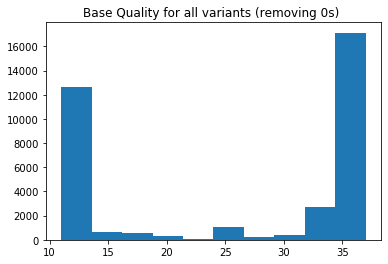

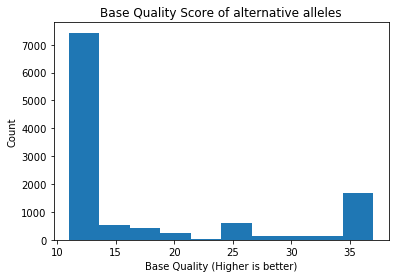

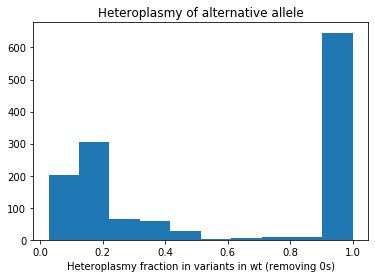

In [11]:
%matplotlib inline
f = plt.figure()
bq_vals = wt_bq_df.values.flatten()
plt.hist(bq_vals[bq_vals>0])
plt.title("Base Quality for all variants (removing 0s) ")
plt.savefig(join(outdir, "wt_base_quality.png"))

plt.figure()
plt.hist(wt_af["Alternative BQ"])
plt.title("Base Quality Score of alternative alleles")
plt.xlabel("Base Quality (Higher is better)")
plt.ylabel("Count")
plt.savefig(join(outdir, "wt_base_quality_altAllele.png"))


f = plt.figure()
af_vals = wt_AF_by_cell.values.flatten()
plt.hist(af_vals[af_vals>0])
plt.title("Heteroplasmy of alternative allele")
plt.xlabel("Heteroplasmy fraction in variants in wt (removing 0s)")
plt.savefig(join(outdir, "wt_heteroplasmy_values.png"))


# flt3

In [12]:
flt3_AF_by_cell, flt3_BQ_by_cell, flt3_af, flt3_bq_df, flt3_nt_df = calculate_af(coverage_flt3_dir, concat_flt3_dir, ref_fasta=ref_fa,AF_F=None, maxBP=maxBP, topN=topN, 
                                                                                 min_cells=min_cells, min_reads=min_reads,
                                                                                min_het_cells=min_het_cells, het_thresh=het_thresh)

no alt count 2020
topN 0
Number of positions to keep : 1927
Number of cells to keep : 2821
Positions that pass het filter: 307


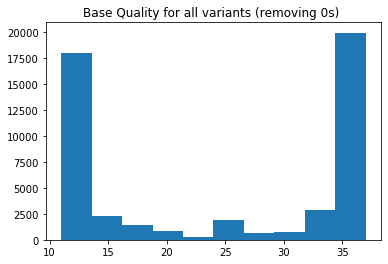

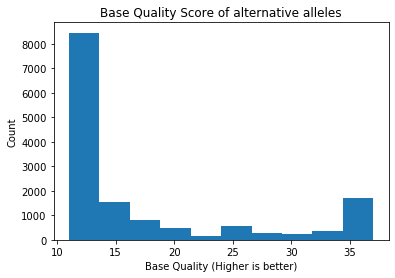

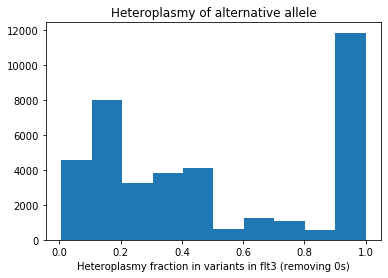

In [13]:
%matplotlib inline
f = plt.figure()
bq_vals = flt3_bq_df.values.flatten()
plt.hist(bq_vals[bq_vals>0])
plt.title("Base Quality for all variants (removing 0s) ")
plt.savefig(join(outdir, "flt3_base_quality.png"))

plt.figure()
plt.hist(flt3_af["Alternative BQ"])
plt.title("Base Quality Score of alternative alleles")
plt.xlabel("Base Quality (Higher is better)")
plt.ylabel("Count")
plt.savefig(join(outdir, "flt3_base_quality_altAllele.png"))


f = plt.figure()
af_vals = flt3_AF_by_cell.values.flatten()
plt.hist(af_vals[af_vals>0])
plt.title("Heteroplasmy of alternative allele")
plt.xlabel("Heteroplasmy fraction in variants in flt3 (removing 0s)")
plt.savefig(join(outdir, "flt3_heteroplasmy_values.png"))


## Merge the two 

In [14]:
flt3_AF_by_cell.index = flt3_AF_by_cell.index + "_flt3"
wt_AF_by_cell.index = wt_AF_by_cell.index + "_wt"


In [15]:
all_cells = pd.concat((wt_AF_by_cell,flt3_AF_by_cell) ,axis=1)


/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [16]:
all_cells_var_overlap = pd.concat((wt_AF_by_cell,flt3_AF_by_cell) ,axis=0, join='inner')
overlap_variants = all_cells_var_overlap.columns.values
all_cells_var_overlap


,8399C,8411C,8412G,8418G,8419G,8425C,9449T,14766T
CTCGGGAAGTATCTCG-1_wt,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ACTATCTAGCTAACAA-1_wt,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAGCATATCCTCAACC-1_wt,0.25,0.0,0.0,0.0,0.0,0.0,0.0,1.0
GAATGAACATCAGTCA-1_wt,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
TGTGTTTTCCAAACAC-1_wt,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
TCACAAGTCTTACCTA-1_flt3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ACACCCTCATGGGACA-1_flt3,0.00,0.0,0.0,0.0,0.0,0.0,0.2,0.0
CGAGAAGTCTAAGCCA-1_flt3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
CGTGTCTCAGAAGCAC-1_flt3,0.00,0.0,0.0,0.1,0.0,0.0,0.0,1.0


Text(0.5, 1.0, 'Overlap of called variants')

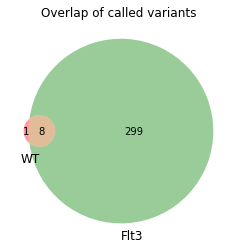

In [17]:
%matplotlib inline
venn2([set(wt_AF_by_cell.columns.values),set(flt3_AF_by_cell.columns.values)],set_labels=["WT","Flt3"])
plt.title("Overlap of called variants")
plt.savefig(join(outdir,"overlap_variants_with_without_ligand.png"))

## Plot the lineage tracing 

### With only the overlapping variants

In [18]:
all_cells_var_overlap = all_cells_var_overlap.drop((all_cells_var_overlap==0).all(axis=0).where(lambda x: x==True).dropna().index,axis=1)

all_cells_var_overlap = all_cells_var_overlap.drop((all_cells_var_overlap==0).all(axis=1).where(lambda x: x==True).dropna().index,axis=0)

In [19]:

row_meta = pd.concat((pd.DataFrame(index=flt3_AF_by_cell.index, data={"Sample":["Flt3"]*flt3_AF_by_cell.index.shape[0]}),
           pd.DataFrame(index= wt_AF_by_cell.index, data={"Sample":["wt"]*wt_AF_by_cell.index.shape[0]})))
row_meta = row_meta.loc[all_cells_var_overlap.index]
row_meta

,Sample
CTCGGGAAGTATCTCG-1_wt,wt
CAGCATATCCTCAACC-1_wt,wt
GAATGAACATCAGTCA-1_wt,wt
TGTGTTTTCCAAACAC-1_wt,wt
CTGCCTATCGGAAACG-1_wt,wt
...,...
TCACAAGTCTTACCTA-1_flt3,Flt3
ACACCCTCATGGGACA-1_flt3,Flt3
CGAGAAGTCTAAGCCA-1_flt3,Flt3
CGTGTCTCAGAAGCAC-1_flt3,Flt3


cmap None


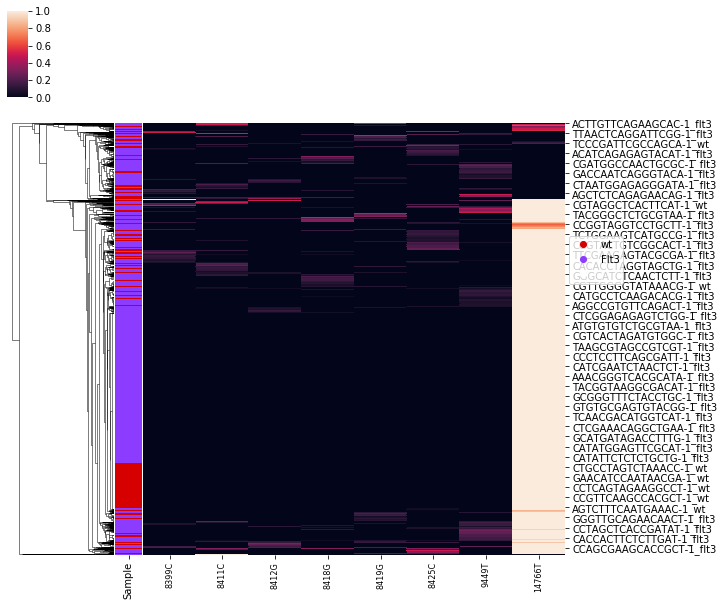

In [20]:
%matplotlib inline
cluster_help.plot_cluster(df=all_cells_var_overlap, row_meta=row_meta, col_meta=None,
                 fsave=None, to_z=False, to_col_clust=False,
                 to_row_clust=True, name=None, col_names=True,
                 row_names=True, to_legend=True, method="average", white_name=None)
plt.savefig(join(outdir,"lineage_OnlyoverlapVariants.png"))

## Plot number of overlapping positions from Flt3 and without

### With all variants

cmap None


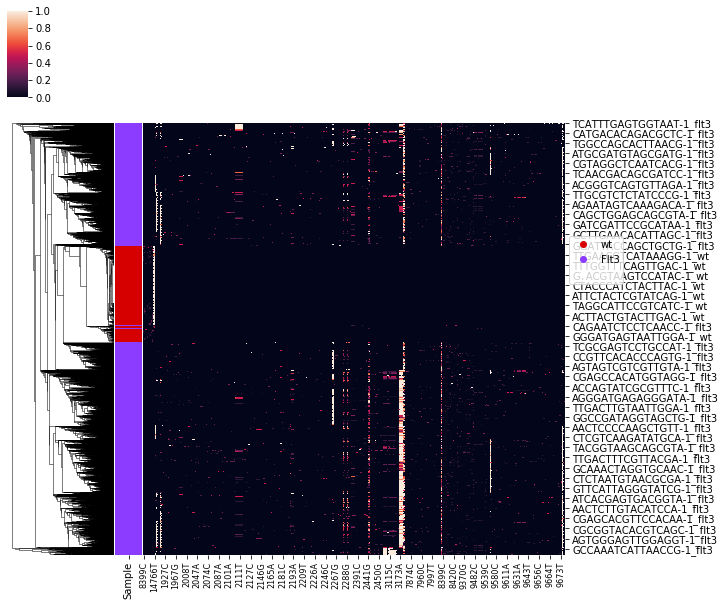

In [21]:
all_cells = all_cells.fillna(0)
all_cells = all_cells.drop((all_cells==0).all(axis=0).where(lambda x: x==True).dropna().index,axis=1)

all_cells = all_cells.drop((all_cells==0).all(axis=1).where(lambda x: x==True).dropna().index,axis=0)

# row_meta = pd.concat((pd.DataFrame(index=flt3_cell, data={"Sample":["Flt3"]*flt3_cell.shape[0]}),
#            pd.DataFrame(index=wt_cell, data={"Sample":["wt"]*wt_cell.shape[0]})))
# row_meta = row_meta.loc[all_cells.index]

row_meta = pd.concat((pd.DataFrame(index=flt3_AF_by_cell.index, data={"Sample":["Flt3"]*flt3_AF_by_cell.index.shape[0]}),
           pd.DataFrame(index= wt_AF_by_cell.index, data={"Sample":["wt"]*wt_AF_by_cell.index.shape[0]})))
row_meta = row_meta.loc[all_cells.index]
row_meta


g = cluster_help.plot_cluster(df=all_cells, row_meta=row_meta, col_meta=None,
                 fsave=None, to_z=False, to_col_clust=False,
                 to_row_clust=True, name=None, col_names=True,
                 row_names=True, to_legend=True, method="average", white_name=None)
plt.savefig(join(outdir,"lineage_AllVariants.png"))

## Scatter the average AF in both samples for each position 


[ 8399  8411  8412  8418  8419  8425  9438  9449 14766   663   709  1816
  1849  1888  1913  1926  1927  1929  1932  1936  1941  1951  1958  1966
  1967  1969  1973  1981  1983  1984  1993  2004  2008  2010  2015  2024
  2028  2031  2033  2042  2047  2053  2054  2057  2058  2063  2068  2073
  2074  2075  2078  2079  2080  2081  2082  2085  2087  2091  2092  2094
  2095  2096  2097  2098  2101  2102  2103  2104  2107  2108  2109  2110
  2111  2112  2113  2114  2115  2117  2120  2121  2127  2128  2129  2131
  2134  2140  2143  2144  2146  2147  2149  2154  2157  2158  2160  2161
  2165  2167  2168  2169  2171  2174  2179  2180  2181  2185  2186  2188
  2189  2190  2191  2192  2193  2198  2199  2201  2202  2203  2206  2207
  2209  2212  2213  2214  2220  2222  2224  2225  2226  2230  2231  2235
  2236  2239  2243  2245  2246  2247  2248  2249  2251  2253  2259  2265
  2267  2270  2274  2277  2281  2283  2285  2287  2288  2289  2290  2291
  2386  2387  2388  2390  2391  2395  2398  2399  2

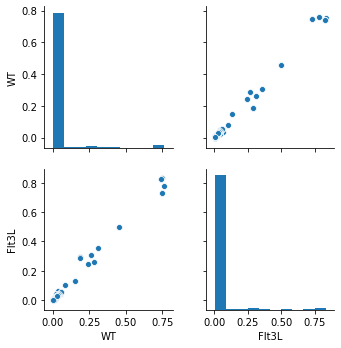

In [22]:
#pd.concat((wt_af, flt3_af))
import numpy as np
overlap_inds = np.array(list(map(lambda x: int(x[:-1]), all_cells.columns)))
print(overlap_inds)
merged_af = pd.DataFrame({"WT":wt_af.loc[overlap_inds,"AF"], "Flt3L":flt3_af.loc[overlap_inds, "AF"]})
merged_af = merged_af.fillna(0)
sns.pairplot(merged_af)
plt.savefig(join(outdir, "heteroplasmy_across_samples"))

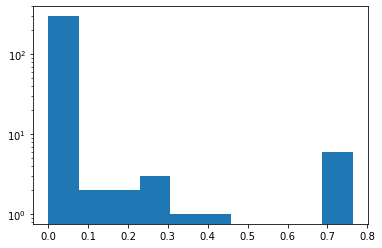

In [23]:
plt.hist((merged_af['WT'].astype(float)))
plt.yscale('log')

## Just using CD34 with no Flt3L

### Here we compare the rest of sequencing techniques done and see if we see the same variants, this ensuring the differences are consistent across the techniques and not technical noise.

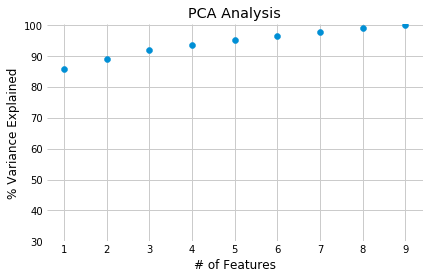

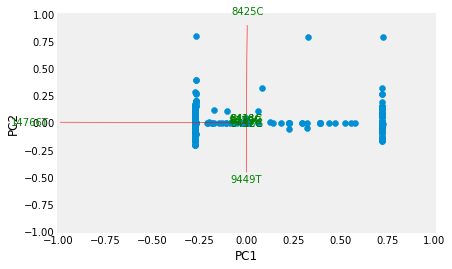

(                       8412G     8425C     9438C  8411C  9449T  8399C  8418G
 CTCGGGAAGTATCTCG-1_wt    0.0  0.000000  0.000000    0.0    0.0   0.00    0.0
 ACTATCTAGCTAACAA-1_wt    0.0  0.000000  0.000000    0.0    0.0   0.00    0.0
 CAGCATATCCTCAACC-1_wt    0.0  0.000000  0.000000    0.0    0.0   0.25    0.0
 GAATGAACATCAGTCA-1_wt    0.0  0.000000  0.000000    0.0    0.0   0.00    0.0
 TGTGTTTTCCAAACAC-1_wt    0.0  0.000000  0.000000    0.0    0.0   0.00    0.0
 ...                      ...       ...       ...    ...    ...    ...    ...
 AACTGGTTCTCTTGAT-1_wt    0.0  0.200000  0.000000    0.0    0.0   0.00    0.0
 TACTCATTCACTCTTA-1_wt    0.0  0.000000  0.333333    0.0    0.0   0.00    0.0
 ACGAGCCTCAACACCA-1_wt    0.0  0.090909  0.000000    0.0    0.0   0.00    0.0
 CATCAAGAGAGCTATA-1_wt    0.0  0.000000  0.000000    0.0    0.0   0.00    0.0
 TTCGAAGGTTGATTCG-1_wt    0.0  0.000000  0.000000    0.0    0.0   0.00    0.0
 
 [917 rows x 7 columns],
 array([[ 4.48622393e-03, -1.64827949

<Figure size 432x288 with 0 Axes>

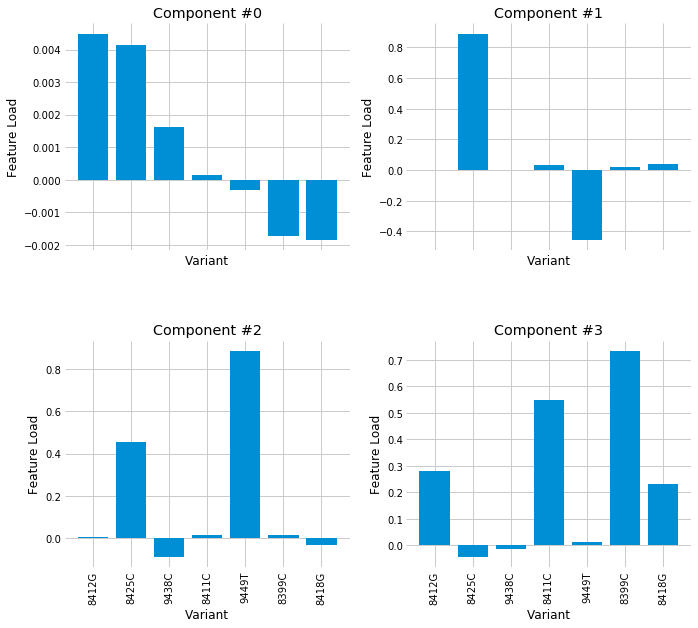

In [24]:
from src.utils import construct_pca
%matplotlib inline
construct_pca(wt_AF_by_cell.copy(), save_f=join(outdir, "wt_pca"))

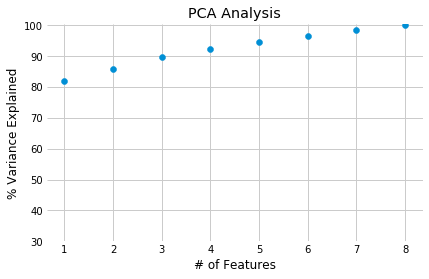

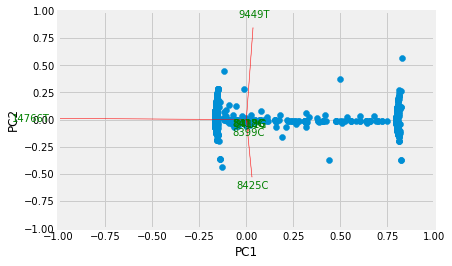

(                         9449T  8425C  8411C  8418G  8399C  8412G  14766T
 CTCGGGAAGTATCTCG-1_wt      0.0    0.0    0.0    0.0   0.00    0.0    1.00
 CAGCATATCCTCAACC-1_wt      0.0    0.0    0.0    0.0   0.25    0.0    1.00
 GAATGAACATCAGTCA-1_wt      0.0    0.0    0.0    0.0   0.00    0.0    1.00
 TGTGTTTTCCAAACAC-1_wt      0.0    0.0    0.0    0.0   0.00    0.0    1.00
 CTGCCTATCGGAAACG-1_wt      0.0    0.0    0.0    0.0   0.00    0.0    0.25
 ...                        ...    ...    ...    ...    ...    ...     ...
 TCACAAGTCTTACCTA-1_flt3    0.0    0.0    0.0    0.0   0.00    0.0    1.00
 ACACCCTCATGGGACA-1_flt3    0.2    0.0    0.0    0.0   0.00    0.0    0.00
 CGAGAAGTCTAAGCCA-1_flt3    0.0    0.0    0.0    0.0   0.00    0.0    1.00
 CGTGTCTCAGAAGCAC-1_flt3    0.0    0.0    0.0    0.1   0.00    0.0    1.00
 GACTGCGTCCATTCTA-1_flt3    0.0    0.0    0.0    0.0   0.00    0.0    1.00
 
 [3200 rows x 7 columns],
 array([[ 0.03519125,  0.84165016,  0.52805517,  0.08319294],
        [ 

<Figure size 432x288 with 0 Axes>

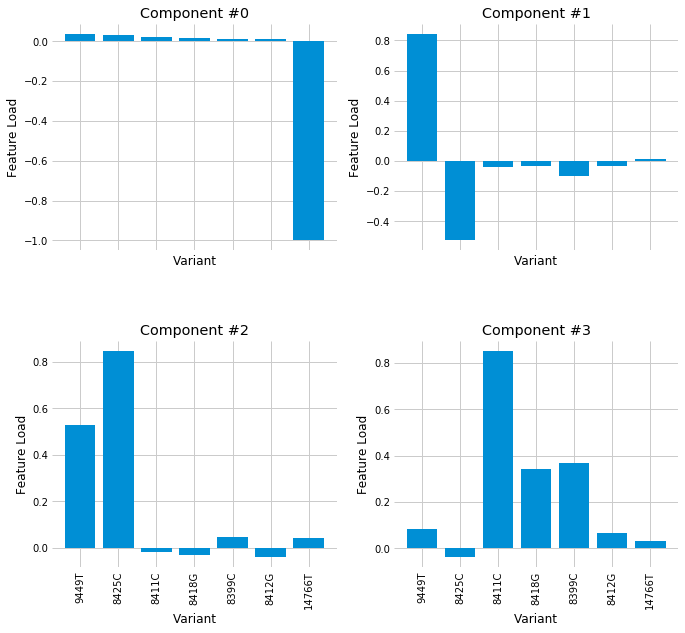

In [25]:

%matplotlib inline
construct_pca(all_cells_var_overlap.copy(), save_f=join(outdir, "pca"))

## Het by value

## Clustering

In [26]:
wt_AF_by_cell

,8399C,8411C,8412G,8418G,8419G,8425C,9438C,9449T,14766T
CTCGGGAAGTATCTCG-1_wt,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0
ACTATCTAGCTAACAA-1_wt,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
CAGCATATCCTCAACC-1_wt,0.25,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0
GAATGAACATCAGTCA-1_wt,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0
TGTGTTTTCCAAACAC-1_wt,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...
AACTGGTTCTCTTGAT-1_wt,0.00,0.0,0.0,0.0,0.000000,0.200000,0.000000,0.0,1.0
TACTCATTCACTCTTA-1_wt,0.00,0.0,0.0,0.0,0.000000,0.000000,0.333333,0.0,1.0
ACGAGCCTCAACACCA-1_wt,0.00,0.0,0.0,0.0,0.000000,0.090909,0.000000,0.0,1.0
CATCAAGAGAGCTATA-1_wt,0.00,0.0,0.0,0.0,0.058824,0.000000,0.000000,0.0,1.0


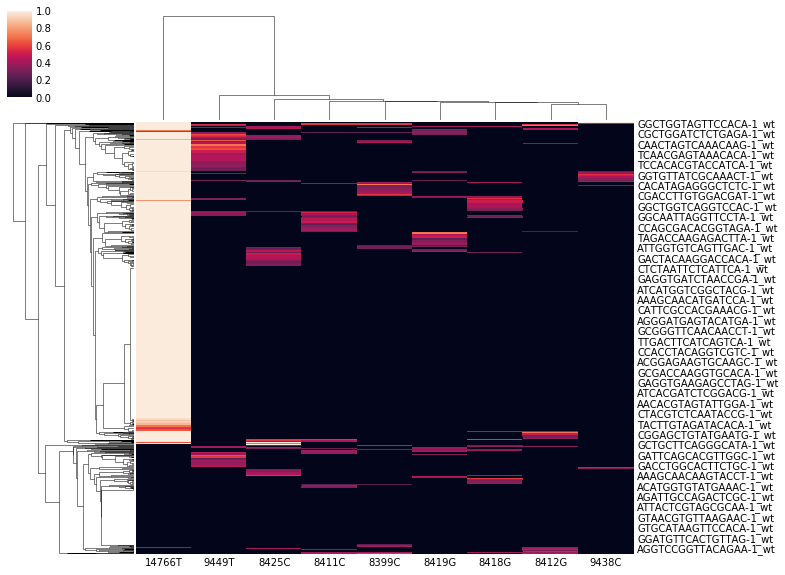

In [27]:
wt_AF_by_cell = wt_AF_by_cell.loc[:,(wt_AF_by_cell>0).any(axis=0)]
sns.clustermap(np.sqrt(wt_AF_by_cell))
plt.savefig(join(outdir, 'wt_clust.png'))

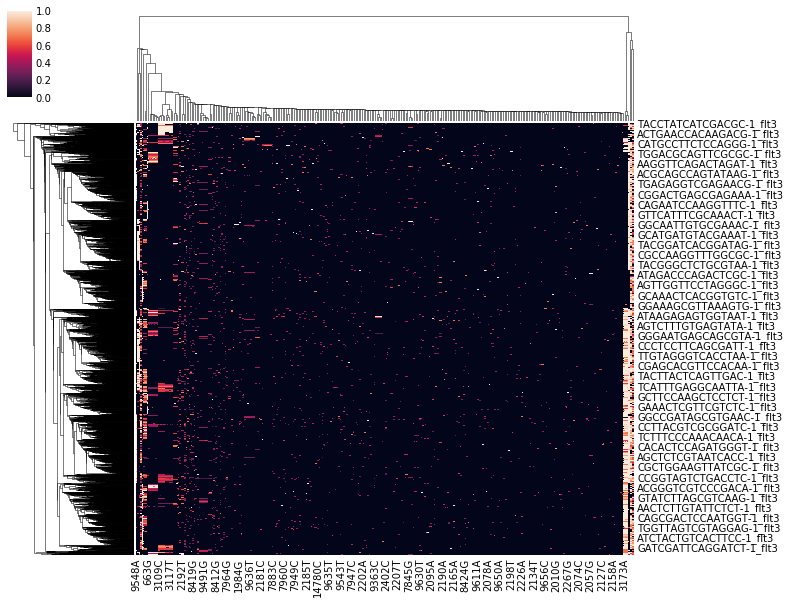

In [28]:
flt3_AF_by_cell = flt3_AF_by_cell.loc[:,(flt3_AF_by_cell>0).any(axis=0)]
sns.clustermap(np.sqrt(flt3_AF_by_cell))
plt.savefig(join(outdir, 'flt3_clust.png'))